<a href="https://colab.research.google.com/github/robd123/AML/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import urllib.request
import os
datapath = os.path.join("datasets", "epi", "")
os.makedirs(datapath, exist_ok=True)
file_path = "https://raw.githubusercontent.com/robd123/AML/main/Project2/epi_r.csv"
urllib.request.urlretrieve(file_path, datapath + "epi_r.csv")

('datasets/epi/epi_r.csv', <http.client.HTTPMessage at 0x7f67dba3b750>)

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

food = pd.read_csv(datapath + "epi_r.csv", thousands=',')
food.sort_values(by=['calories'], ascending=False).head()


,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,advance prep required,alabama,alaska,alcoholic,almond,amaretto,anchovy,anise,anniversary,anthony bourdain,aperitif,appetizer,apple,apple juice,apricot,arizona,artichoke,arugula,asian pear,asparagus,aspen,atlanta,australia,avocado,back to school,backyard bbq,bacon,bake,banana,...,vegan,vegetable,vegetarian,venison,vermont,vermouth,vinegar,virginia,vodka,waffle,walnut,wasabi,washington,"washington, d.c.",watercress,watermelon,wedding,weelicious,west virginia,westwood,wheat/gluten-free,whiskey,white wine,whole wheat,wild rice,windsor,wine,winter,wisconsin,wok,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
11391,Pear-Cranberry Mincemeat Lattice Pie,4.375,30111218.0,200968.0,1722763.0,27675110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6368,Deep-Dish Wild Blueberry Pie,4.375,29997918.0,200210.0,1716279.0,27570999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19672,"Apricot, Cranberry and Walnut Pie",4.375,13062948.0,87188.0,747374.0,12005810.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2976,Lamb Köfte with Tarator Sauce,5.000,4518216.0,166471.0,44198.0,7540990.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9731,"Rice Pilaf with Lamb, Carrots, and Raisins",5.000,4157357.0,236489.0,221495.0,3134853.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Data Preprocessing**


*   Replace missing values with median values.
*   Use standard scaler.
*   Remove all foods with more than 10000 calories.  There are some extreme outliers that are physically impossible. I don't know how big a pie would need to be to have thirty million calories, so it's safe to assume the data is wrong.
*   Also remove food with less than 50 calories, most of these are recipes for preparing ingredients like stock or clarified butter.  Since we're trying to rate meals they can be safely removed.
*   A gram of fat has 9 calories and a gram of protein has 4 calories.  Remove any food that has fewer calories than nutritionally possible.
*   I'm assuming that sodium is measured in milligrams, so will be removing anything over 20000.  40 grams is roughly the lethal limit for sodium, so removing any recipe with over half the lethal amount seems safe.

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

food_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

food = food[food.calories < 10000]  # Remove impossible foods
food = food[food.calories > 50]  # Remove ingredients
food = food[food.sodium < 20000]  # Remove lethal foods
food = food[food.calories >= (4 * food.protein + 9 * food.fat)]  # Remove foods that don't make sense calorically

food = food.drop_duplicates(keep='first')

food_data = food[['rating', 'calories', 'protein', 'fat', 'sodium']]

food_tr = food_pipeline.fit_transform(food_data)
food_scaled = pd.DataFrame(food_tr, columns=['rating', 'calories', 'protein', 'fat', 'sodium'])


In [48]:
food.sort_values(by=['sodium'], ascending=False).head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,advance prep required,alabama,alaska,alcoholic,almond,amaretto,anchovy,anise,anniversary,anthony bourdain,aperitif,appetizer,apple,apple juice,apricot,arizona,artichoke,arugula,asian pear,asparagus,aspen,atlanta,australia,avocado,back to school,backyard bbq,bacon,bake,banana,...,vegan,vegetable,vegetarian,venison,vermont,vermouth,vinegar,virginia,vodka,waffle,walnut,wasabi,washington,"washington, d.c.",watercress,watermelon,wedding,weelicious,west virginia,westwood,wheat/gluten-free,whiskey,white wine,whole wheat,wild rice,windsor,wine,winter,wisconsin,wok,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
4711,"Pizza Bianca with Prosciutto, Arugula, and Par...",3.750,2054.0,222.0,90.0,19986.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9779,Herb-Roasted Turkey with Apple Cider Gravy,4.375,1182.0,140.0,55.0,19149.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12061,Brined and Barbecued Turkey,4.375,1246.0,150.0,48.0,18898.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5445,Lamb and Broccoli Stew,3.750,1321.0,56.0,103.0,17544.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12407,Dan's Baked Stuffed Shrimp,4.375,2810.0,389.0,73.0,16988.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
food_data.describe()

,rating,calories,protein,fat,sodium
count,13878.000000,13878.000000,13878.000000,13878.000000,13878.000000
mean,3.777517,516.193111,22.338305,29.370803,620.814094
std,1.255327,605.035747,38.090420,43.623257,1127.320688
min,0.000000,51.000000,0.000000,0.000000,0.000000
25%,3.750000,219.000000,4.000000,9.000000,100.000000
50%,4.375000,360.000000,9.000000,19.000000,319.000000
75%,4.375000,610.000000,29.000000,35.000000,745.750000
max,5.000000,9831.000000,1114.000000,923.000000,19986.000000


In [49]:
food_scaled.describe()

,rating,calories,protein,fat,sodium
count,1.387800e+04,1.387800e+04,1.387800e+04,1.387800e+04,1.387800e+04
mean,1.101983e-16,-3.891940e-17,1.288620e-16,-1.568376e-17,-5.212720e-17
std,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00
min,-3.009298e+00,-7.688965e-01,-5.864758e-01,-6.733074e-01,-5.507186e-01
25%,-2.192064e-02,-4.912170e-01,-4.814588e-01,-4.669880e-01,-4.620095e-01
50%,4.759756e-01,-2.581645e-01,-3.501874e-01,-2.377442e-01,-2.677366e-01
75%,4.759756e-01,1.550491e-01,1.748979e-01,1.290458e-01,1.108295e-01
max,9.738718e-01,1.539602e+01,2.866078e+01,2.048589e+01,1.717868e+01


In [41]:
food_scaled.corr()['rating'].sort_values(ascending=False)

rating      1.000000
fat         0.085976
protein     0.085094
calories    0.077258
sodium      0.023770
Name: rating, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3566ef6c50>,
      dtype=object)

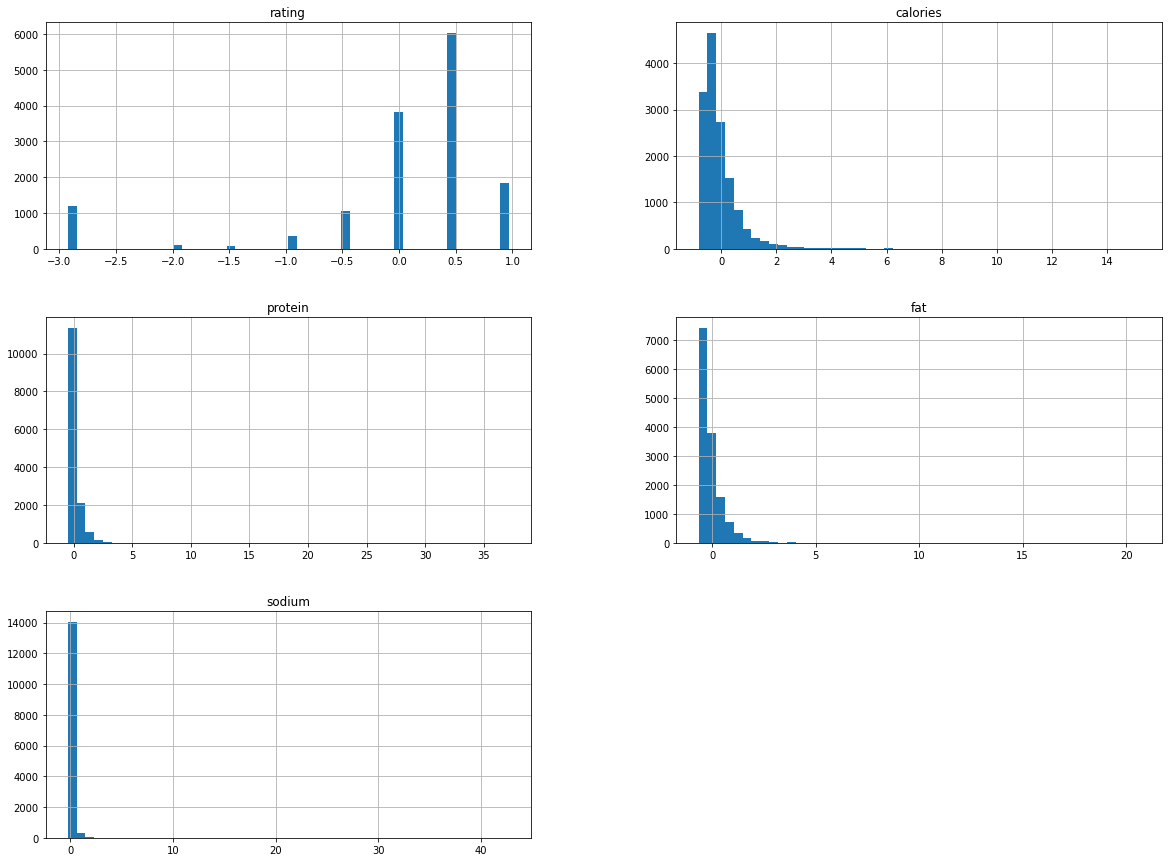

In [61]:
food_scaled.hist(bins=50, figsize=(20,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f67daea7c90>,
      dtype=object)

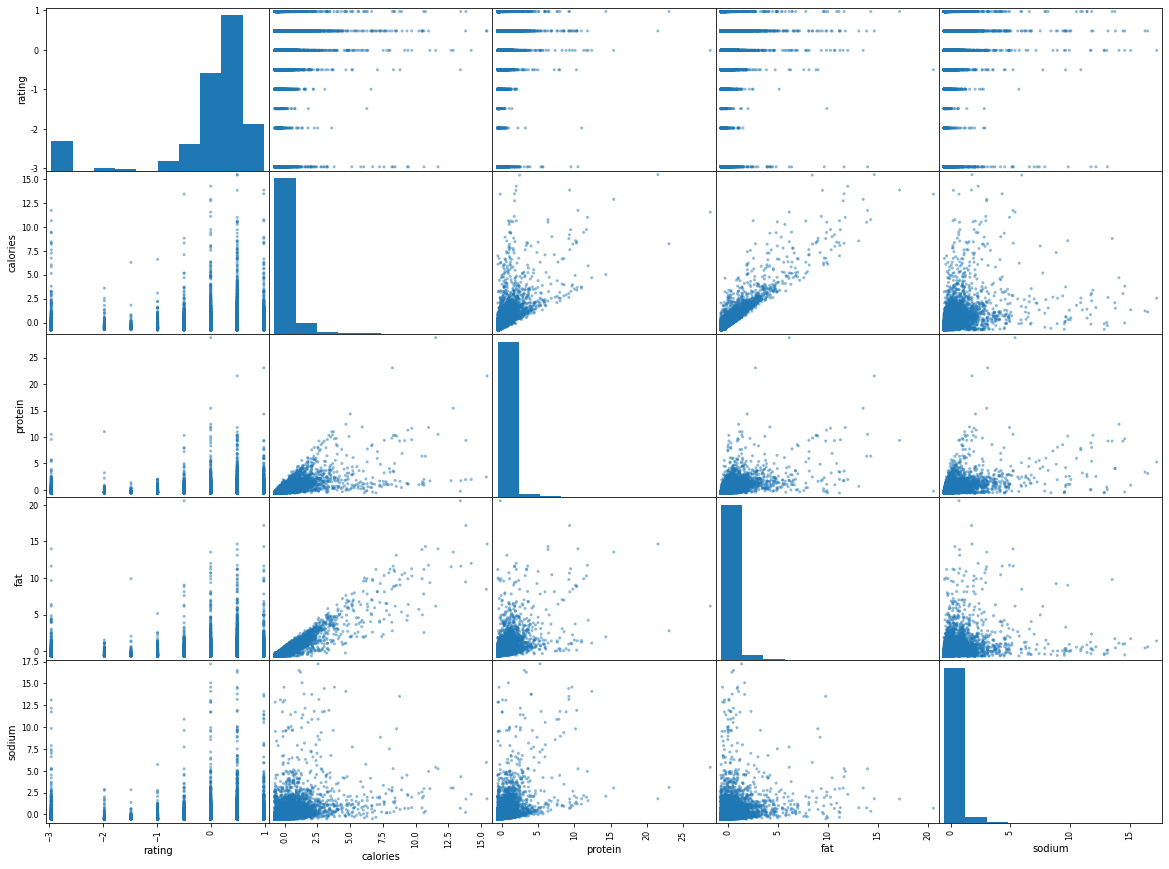

In [44]:
from pandas.plotting import scatter_matrix

attributes = ['rating', 'calories', 'protein', 'fat', 'sodium']
scatter_matrix(food_scaled[attributes], figsize=(20,15))
